In [1]:
%load_ext autoreload

In [2]:
%autoreload 3

In [3]:
import sys
sys.path.append('../')

In [9]:
import copy, pdb, json, pprint, glob, cv2, logging, os
import numpy as np
from matplotlib import pyplot as plt
from yaml import safe_load
from utils import load_domain

In [5]:
from detectors import Dataset
from hypersearch import OptunaOptimization
from criteria import Label, accuracy, iou

In [6]:
from ext import SddCxxParameter, SddCxx

In [7]:
logger = logging.getLogger()
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

# Load dataset

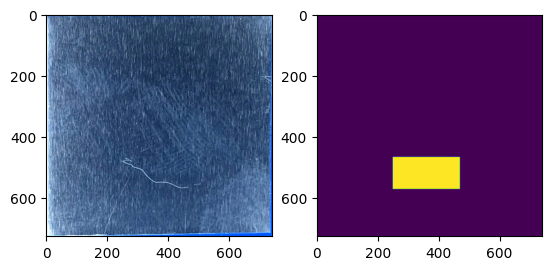

In [8]:
#Note: Set the path to your dataset
data_path = "../data/evaluation_data/metal/"
label_path = data_path
imgs = []
imgs_path = []
masks = []
masks_path = []
ground_truth = []
labels = []

for filename in glob.glob(data_path + 'Train/OK/*.jpg', recursive=True):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)
    imgs_path.append(filename)
    masks.append(np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8))
    ground_truth.append(np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8))
    labels.append(0)

for filename in glob.glob(data_path + 'Train/NG/*.jpg', recursive=True):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img)  
    imgs_path.append(filename)
    masks.append(np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8))
    labels.append(0)

for filename in glob.glob(label_path + 'Train/*.json', recursive=True):
    with open(filename, "r") as f:
        json_data = json.load(f)

    img = cv2.imread(data_path + 'Train/NG/' + json_data['name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    size = img.shape
    mask =  np.zeros(size[:2], dtype=np.uint8)
    
    for rect_list in json_data['rect']:
        x, y   = rect_list['rect']['coord']
        dx, dy = rect_list['rect']['size']
        mask[y:y + dy, x:x + dx] = 1
    ground_truth.append(mask)

num = -1
plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(imgs[num])
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(ground_truth[num])

In [9]:
dataset = Dataset(imgs, masks, ground_truth, labels, imgs_path, masks_path)

In [10]:
with open('../settings.yml', 'r') as fp:
    settings = safe_load(fp)

In [11]:
settings

{'dataset_dir': 'dataset',
 'imgs_dir': 'imgs',
 'mask_dir': 'mask',
 'ground_truth_dir': 'ground_truth',
 'algorithm': 'PSD',
 'save_dir': 'Model'}

In [13]:
dic = load_domain('../domain.json')

In [14]:
dic['LPD']

[{'name': 'alg', 'type': 'fixed', 'domain': 'LocalPatternDetector'},
 {'name': 'license_path',
  'type': 'fixed',
  'domain': 'license/node-locked.lic'},
 {'name': 'patch_size_height', 'type': 'discrete', 'domain': [16, 32]},
 {'name': 'patch_size_width', 'type': 'discrete', 'domain': [16, 32]},
 {'name': 'extraction_step_height', 'type': 'discrete', 'domain': [8, 16]},
 {'name': 'extraction_step_width', 'type': 'discrete', 'domain': [8, 16]},
 {'name': 'n_bins', 'type': 'discrete', 'domain': [2, 20]},
 {'name': 'radius', 'type': 'discrete', 'domain': [1, 10]},
 {'name': 'diameter', 'type': 'discrete', 'domain': [1, 15]},
 {'name': 'sigmaColor', 'type': 'discrete', 'domain': [10, 150]},
 {'name': 'sigmaSpace', 'type': 'discrete', 'domain': [10, 150]},
 {'name': 'b_lmc', 'type': 'fixed', 'domain': False},
 {'name': 'b_fha', 'type': 'fixed', 'domain': True},
 {'name': 'threshold', 'type': 'continuous', 'domain': [0.0001, 1.0]},
 {'name': 'area', 'type': 'continuous', 'domain': [1.0, 2000

In [15]:
dic["DRD"][1]['domain'] = '../license/node-locked.lic'

In [15]:
pt = OptunaOptimization(dataset=dataset, criteria=iou,
                        param_space=dic['DRD'], settings=settings, show_progress_bar=True, timeout=1,
                        threshold=0.0001, area=10)

best_score = 0
best_param = {}
res=pt.optimize()
print("tried parameters:", res[0])
best_score = res[1]
best_param = res[0]
        
print(best_score)
print(best_param)

start Optuna optimization


[I 2023-02-16 14:41:29,474] A new study created in memory with name: hyper tune
C:\Users\hacarus\source\repos\hacarus-check-hyper-search\src\backend\.venv\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


   0%|          | 00:00/00:01

[I 2023-02-16 14:41:57,150] Trial 0 finished with value: 0.006311004298254583 and parameters: {'patch_size_height': 23, 'patch_size_width': 28, 'extraction_step_height': 8, 'extraction_step_width': 10, 'deviation_step': 0.5255920833696278, 'n_components': 2, 'max_iter': 26, 'n_nonzero_coefs': 8, 'b_ss_mean': True, 'b_ss_scale': True}. Best is trial 0 with value: 0.006311004298254583.
tried parameters: {'patch_size_height': 23, 'patch_size_width': 28, 'extraction_step_height': 8, 'extraction_step_width': 10, 'deviation_step': 0.5255920833696278, 'n_components': 2, 'max_iter': 26, 'n_nonzero_coefs': 8, 'b_ss_mean': True, 'b_ss_scale': True, 'license_path': '../license/node-locked.lic'}
0.006311004298254583
{'patch_size_height': 23, 'patch_size_width': 28, 'extraction_step_height': 8, 'extraction_step_width': 10, 'deviation_step': 0.5255920833696278, 'n_components': 2, 'max_iter': 26, 'n_nonzero_coefs': 8, 'b_ss_mean': True, 'b_ss_scale': True, 'license_path': '../license/node-locked.lic'

In [16]:
latest_model_path = sorted(glob.glob(os.path.join(settings['save_dir'], "*")))[-1]

In [17]:
scp = SddCxxParameter()

In [18]:
scp.load(os.path.join(latest_model_path,"DRD",'parameter_1_1.json'))
scp.param.license.lic = '../license/node-locked.lic'
scp.param.psd.onnx = "../distfiles/wide_resnet50_2.onnx"

In [19]:
sc = SddCxx(scp = scp)

In [20]:
sc.load(path = os.path.join(latest_model_path, "DRD", "ctx_1_1.pb"))

In [21]:
paths = [
    "../data/evaluation_data/metal/Test/NG/IMG_1412-NG.jpg",
    "../data/evaluation_data/metal/Test/NG/IMG_1413-NG.jpg",
    "../data/evaluation_data/metal/Test/NG/IMG_1414-NG.jpg"
]
imgs = []
anomaly_imgs = []
for path in paths:
    gray = cv2.imread(path, 0)
    anomaly_img = np.empty(shape = gray.shape[:2], dtype = np.float64) # NOTE: anomaly_img should be pre-allocated.
    imgs.append(gray)
    anomaly_imgs.append(anomaly_img)

In [22]:
sc.predict(imgs = imgs, anomaly_imgs = anomaly_imgs)

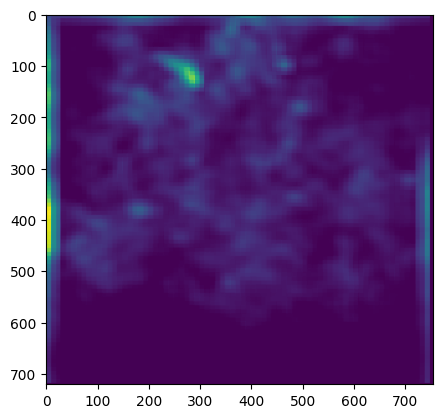

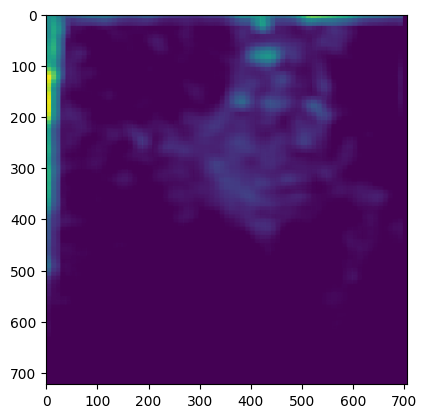

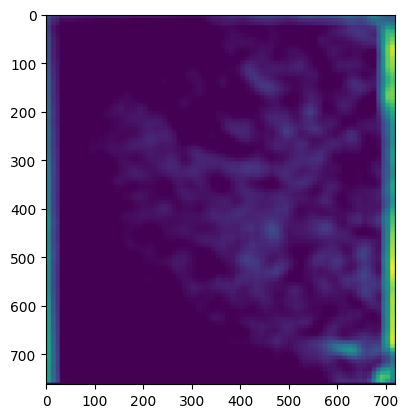

In [23]:
for im in anomaly_imgs:
    plt.figure()
    plt.imshow(im)

# LPD

In [16]:
raspberry_pi_train_path = glob.glob('../data/evaluation_data/raspberry_pi/train/*.png')
raspberry_pi_train_imgs = [cv2.imread(i) for i in raspberry_pi_train_path]
raspberry_pi_test_path = glob.glob('../data/evaluation_data/raspberry_pi/test/*/*.png')
raspberry_pi_test_imgs = [cv2.imread(i) for i in raspberry_pi_test_path]
raspberry_pi_path = raspberry_pi_train_path + raspberry_pi_test_path
raspberry_pi_imgs = raspberry_pi_train_imgs + raspberry_pi_test_imgs

In [17]:
raspberry_pi_gt = []
raspberry_pi_masks = []
raspberry_pi_labels = []
for ct, i in enumerate(raspberry_pi_path):
    mask_path = i.replace('test', 'mask')
    if (os.path.exists(mask_path) and (not ('train' in mask_path))):
        gt = cv2.imread(mask_path, 0)
        _, gt = cv2.threshold(gt, 254, 1, cv2.THRESH_BINARY)
        raspberry_pi_gt.append(gt)
    else:
        raspberry_pi_gt.append(np.zeros((raspberry_pi_imgs[ct].shape[0], raspberry_pi_imgs[ct].shape[1]), dtype=np.uint8))
    raspberry_pi_masks.append(np.zeros((raspberry_pi_imgs[ct].shape[0], 
                                        raspberry_pi_imgs[ct].shape[1]), dtype=np.uint8))
    if 'NG' in i:
        raspberry_pi_labels.append(1)
    else:
        raspberry_pi_labels.append(0)

In [18]:
dataset_raspberry_pi = Dataset(raspberry_pi_imgs, raspberry_pi_masks, raspberry_pi_gt, raspberry_pi_labels, raspberry_pi_path, [])

In [19]:
dic['LPD'][1]['domain']="../license/node-locked.lic"

In [ ]:
pt = OptunaOptimization(dataset=dataset_raspberry_pi, criteria=iou,
                        param_space=dic['LPD'], settings=settings, show_progress_bar=True, timeout=10,
                        threshold=None, area=None)

best_score = 0
best_param = {}
res=pt.optimize()
print("tried parameters:", res[0])
best_trial = res[2]
best_score = res[1]
best_param = res[0]
        
print(best_score)
print(best_param)

start Optuna optimization


[I 2023-05-19 11:24:59,722] A new study created in memory with name: hyper tune
C:\Users\ippei\source\repos\hacarus-check-hyper-search\src\backend\.venv\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


   0%|          | 00:00/00:10

model_params: {'alg': 'LocalPatternDetector', 'license_path': '../license/node-locked.lic', 'patch_size_height': 23, 'patch_size_width': 28, 'extraction_step_height': 8, 'extraction_step_width': 10, 'n_bins': 4, 'radius': 1, 'diameter': 3, 'sigmaColor': 58, 'sigmaSpace': 65, 'b_lmc': False, 'b_fha': True, 'combine_method': 'submaxmul', 'combine_weights': SddCxxAnomalyList[0, 0], 'combine_gamma': 2.0, 'smooth_method': 'bi', 'smooth_gamma': 0.5, 'partial_method': 'naive', 'partial_weights': SddCxxAnomalyList[0, 0, 0, 0, 0]}


In [29]:
best_trial.params

{'patch_size_height': 23,
 'patch_size_width': 28,
 'extraction_step_height': 8,
 'extraction_step_width': 10,
 'n_bins': 4,
 'radius': 1,
 'diameter': 3,
 'sigmaColor': 58,
 'sigmaSpace': 65,
 'threshold': 0.5388628523299566,
 'area': 838.9698342921863}

In [30]:
best_score

0.0015819447373971738

In [31]:
best_trial.user_attrs

{'alg': 'LocalPatternDetector',
 'license_path': '../license/node-locked.lic',
 'b_lmc': False,
 'b_fha': True}

In [32]:
latest_model_path = sorted(glob.glob(os.path.join(settings['save_dir'], "*")))[-1]

In [33]:
scp = SddCxxParameter()

In [34]:
scp.load(os.path.join(latest_model_path,"LPD",'parameter_1_1.json'))
scp.param.license.lic = '../license/node-locked.lic'
scp.param.psd.onnx = "../distfiles/wide_resnet50_2.onnx"

In [35]:
sc = SddCxx(scp = scp)

In [36]:
sc.load(path = os.path.join(latest_model_path, "LPD", "ctx_1_1.pb"))

In [37]:
paths = [
    "../data/raspberry_pi/test/NG/ng_0.png",
    "../data/raspberry_pi/test/NG/ng_1.png",
    "../data/raspberry_pi/test/NG/ng_10.png"
]
imgs = []
anomaly_imgs = []
for path in paths:
    gray = cv2.imread(path, 0)
    anomaly_img = np.empty(shape = gray.shape[:2], dtype = np.float64) # NOTE: anomaly_img should be pre-allocated.
    imgs.append(gray)
    anomaly_imgs.append(anomaly_img)

In [38]:
sc.predict(imgs = imgs, anomaly_imgs = anomaly_imgs)

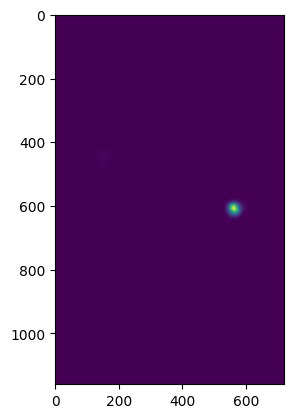

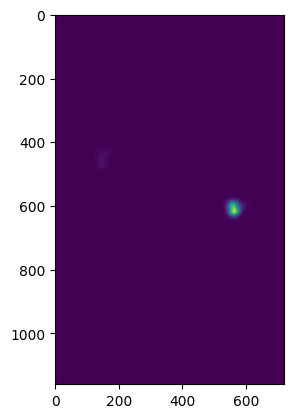

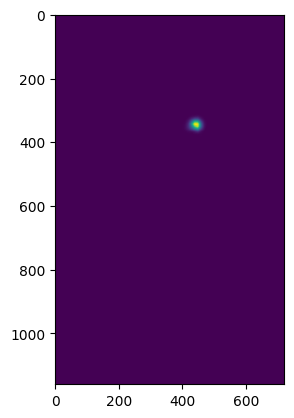

In [39]:
for im in anomaly_imgs:
    plt.figure()
    plt.imshow(im)

###  PSD

In [40]:
dic['PSD'][1]['domain']="../license/node-locked.lic"
dic['PSD'][2]['domain']="../distfiles/wide_resnet50_2.onnx"

In [41]:
pt = OptunaOptimization(dataset=dataset_raspberry_pi, criteria=iou,
                        param_space=dic['PSD'], settings=settings,show_progress_bar=True, timeout=10,
                        threshold=None, area=None)

best_score = 0
best_param = {}
res=pt.optimize()
print("tried parameters:", res[0])
best_trial = res[2]
best_score = res[1]
best_param = res[0]
        
print(best_score)
print(best_param)

start Optuna optimization


[I 2023-02-16 14:42:34,828] A new study created in memory with name: hyper tune
C:\Users\hacarus\source\repos\hacarus-check-hyper-search\src\backend\.venv\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


   0%|          | 00:00/00:10

[I 2023-02-16 14:43:55,502] Trial 0 finished with value: 0.0 and parameters: {'n_features': 232, 'ridge': 0.7231212485077365, 'b_soe': True, 'b_aer': False, 'threshold': 0.19313010568883546, 'area': 69.7665846815665}. Best is trial 0 with value: 0.0.
tried parameters: {'n_features': 232, 'ridge': 0.7231212485077365, 'b_soe': True, 'b_aer': False, 'license_path': '../license/node-locked.lic', 'onnx': '../distfiles/wide_resnet50_2.onnx'}
0.0
{'n_features': 232, 'ridge': 0.7231212485077365, 'b_soe': True, 'b_aer': False, 'license_path': '../license/node-locked.lic', 'onnx': '../distfiles/wide_resnet50_2.onnx'}


In [42]:
scp = SddCxxParameter()

In [43]:
latest_model_path = sorted(glob.glob(os.path.join(settings['save_dir'], "*")))[-1]

In [44]:
scp.load(os.path.join(latest_model_path,"PSD",'parameter_1_1.json'))
scp.param.license.lic = '../license/node-locked.lic'
scp.param.psd.onnx = "../distfiles/wide_resnet50_2.onnx"

In [45]:
sc = SddCxx(scp = scp)

In [46]:
sc.load(path = os.path.join(latest_model_path, "PSD", "ctx_1_1.pb"))

In [47]:
paths = [
    "../data/raspberry_pi/test/NG/ng_0.png",
    "../data/raspberry_pi/test/NG/ng_1.png",
    "../data/raspberry_pi/test/NG/ng_10.png"
]
color_imgs = []
anomaly_imgs = []
for path in paths:
    bgr = cv2.imread(path)
    anomaly_img = np.empty(shape = bgr.shape[:2], dtype = np.float64) # NOTE: anomaly_img should be pre-allocated.
    color_imgs.append(bgr)
    anomaly_imgs.append(anomaly_img)

In [48]:
sc.predict(color_imgs = color_imgs, anomaly_imgs = anomaly_imgs)

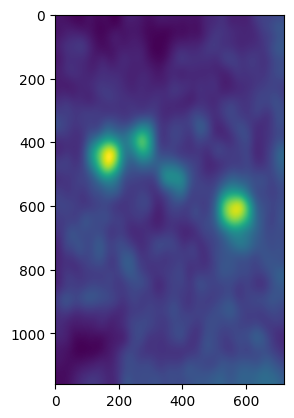

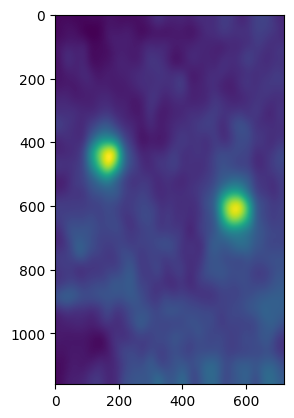

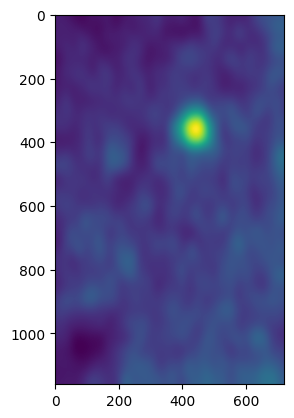

In [49]:
for im in anomaly_imgs:
    plt.figure()
    plt.imshow(im)